# Notebook initialization

In [2]:
from init import *
from IPython.display import clear_output
%matplotlib inline

[monochrome_palette]: value was greater than 1 and was clipped.



import os
import builtins
from collections import OrderedDict, Iterable, namedtuple, deque
import logging
from multiprocessing import Pool
from zipfile import BadZipFile  # For detecting corrupt files
import numpy as np
from functools import partial
from mp_lru_cache import lru_cache  # Local version of lru_cache, specialized for multiprocessing
from scipy.special import lambertw
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import luigi
import mlluigi
mlluigi.set_logging_level('WARNING')

import theano
from tqdm import tqdm_notebook as tqdm
from parameters import ParameterSet

import theano_shim as shim
import mackelab as ml
import mackelab.iotools
import sinn
from sinn.histories import Series
import sinn.analyze as anlz
import sinn.models

logger = logging.getLogger("linearized_tanh")

plt.style.use('publish')
#plt.style.use('dark_background')
#plt.style.use('default')
plt.rcParams['figure.facecolor'] = (1,1,1,

In [3]:
import core
import plot
#plt.style.use('dark_background')

# Models

## Parameters

|||
|---|------------|
| α | Slope at 0 |
| β | Half the linear range
| Δ | Delay
| q | Noise amplitude
| dt | Time step
| T | Total simulation time

## Equations
$$\frac{dX}{dt} = F(X) \,dt + q\,dW$$

Tanh model
$$F(X) = 2\alpha\beta \, \tanh \frac{X}{2\beta} $$

Linear Model
$$F(X) = \alpha\, X$$

In [4]:
from models import Model

# These definitions are also in models.py
class TanhModel(Model):
    @staticmethod
    def F(x, α, β):
        return α*(2*β) * shim.tanh(x/(2*β))

class LinearModel(Model):
    @staticmethod
    def F(x, α, β):
        return α * x

In [5]:
ModelParams = TanhModel.Parameters
params = TanhModel.Parameters()  # Get default parameters
# Workaround current limitation of sinn.models to make params picklable
Params = namedtuple('Params', params._fields)
params = Params(**params._asdict())

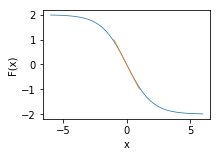

In [6]:
α = params.α; β = params.β;
plt.figure(figsize=(3,2));
xarr = np.linspace(-6*β, 6*β); yarr = TanhModel.F(xarr, α, β); plt.plot(xarr, yarr);
xarr = np.linspace(-β, β); yarr = LinearModel.F(xarr, α, β); plt.plot(xarr, yarr);
plt.xlabel('x'); plt.ylabel('F(x)');
del α, β

# Determining required simulation time

Since we want to compute statistics of the stationary state, we need to know how the system takes to reach this state in simulation time. We produced around 1000 realizations, from which we compute Monte Carlo estimates of the time dependent mean ($\mu(t)$) and standard deviation ($\sigma(t)$). Plotting these as a function of $t$, we see that already at $t=2$, $σ(t)$ has almost reached its maximum, and that by $\sigma(4)$ the function is constant. Since a state has length $\Delta=1$, we set $T=5$ as the point at which we will probe the stationary distribution.

Each realization is initialized with a white noise initial condition (specifically, the drift component of the SDDE). Having a different initial condition for each sample ensures that the cross-correlation between samples is zero. This is important because the linear system is capable of exhibiting strong stochastic reasonance: with our default parameters, significant autocorrelation remains even at lags 100 times longer than the delay time.

In [93]:
seeds = list(range(6**4))
#seeds = list(range(100))
X = core.Realizations(TanhModel, params, seeds, cores=12,
                      T=7.5, statelen=params.Δ, datadir='data')
# X denotes an ensemble of realizations corresponding with the different seeds
X.set()
# set() ensures that all realizations are already computed

In [94]:
tarr = np.linspace(0.1, X.T, 20)[:-1]
    # Drop last term in case some histories weren't computed to end
X.T = 5.  # Set probe time at 5

In [96]:
# WARNING: with 1000 realizations, this cell takes a few minutes on 12 cores

μarr = X.μ(tarr).flatten()
σarr = X.σ(tarr).flatten()

# The multiple progress bars produce some weird output here, which I think is due
# to a bug in Jupyter Widgets.
# To remove it, after the cell as been executed, convert the cell to Markdown then
# back to code (select cell – ESC – m – y).
# Or just re-execute the cell; this will hit the cache and skip the iterations.

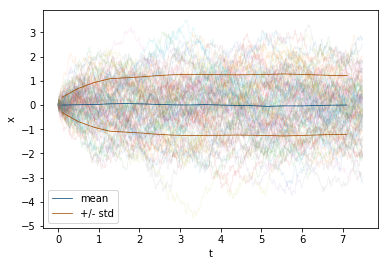

In [97]:
for trace in X.traces()[:100]:
    anlz.plot(trace, alpha=0.11, label='_')

plt.plot(tarr, μarr, label='mean', color=plot.darkcolors[0]);
plt.plot(tarr, σarr, label='+/- std', color=plot.darkcolors[1]);
plt.plot(tarr, -σarr, label='_', color=plot.darkcolors[1]);
plt.xlabel("t")
plt.ylabel("x")
plt.legend(loc='best');

## Empirical estimate of auto- and cross-covariance $\renewcommand{\vec}{\boldsymbol}$
A more stringent test for the choice of $T$ is computing the cross-covariance across realizations, and checking that it approaches zero.

We simulate the system for a time $T$ (the value of $T$ was explored in the section above and set to $5\Delta$) and record the state at $t = T$. A *state* of the system is a function $x(t)$ over $[t-\Delta, t]$ such that $x_τ(t) = x_0(t-\tau)$. For numerical applications this state becomes a discretized vector $\vec{x}(t)$.

The covariance is calculated by discretizating the states $x^{(i)}(T)$ with steps $Δ_{lag} = 0.01$:&nbsp;&nbsp; 
$\vec{x}^{(i)}(T) = \begin{pmatrix} x_0^{(i)}(T)\\ x_{Δ_{lag}}^{(i)}(T)\\ \vdots \end{pmatrix}$, where $i$ denotes the realization. We then compute

\begin{align}
    \vec{\mu} &= \frac{1}{N} \sum_{i = 1}^N \vec{x}^{(i)}  \\
    \boldsymbol{\Sigma} &= \frac{1}{N} \sum_{i = 0}^N \vec{x}^{(i)\,\intercal} \; \vec{x}^{(i)} \,.  \\
\end{align}
Since the system is simulated with time step $Δ_{sim} = 0.001$, the discretization is accomplished by decimating the simulated traces. We use decimation (where only every $n$-th data point is kept) rather than subsampling (where disjoint windows of $n$ data points are averaged) because we want the point-wise covariance.

We check that autocovariance is strongest along the diagonal (corresponding to variance) and that it has roughly constant amplitude.
We then check that the realizations are uncorrelated by computing the 'cross-covariance', i.e. the same formula as the covariance but where the multiplied terms come from different realizations. Since the maximum cross-covariance is less than 5% of the maximum covariance (and continues to drop as we average across more realizations), we determine that $T$ is long enough to consider the traces uncorrelated.

The `Realizations` class uses `stateμ` and `stateΣ` to denote $\vec{\mu}$ and $\boldsymbol{\Sigma}$, to distinguish from the pointwise `μ` and `Σ`.

In [13]:
cov = anlz.ScalarAxisData('Σ', 'density', 
                          data=X.stateΣ(),
                          param_axes=[X.lag_axis, X.lag_axis])

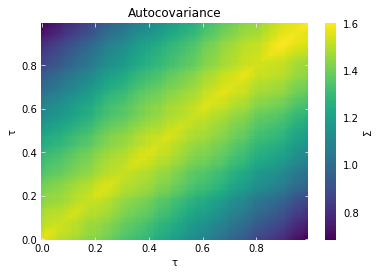

In [15]:
plt.title("Autocovariance")
cov.plot(axes=[0,1]);

In [7]:
X.crossΣ?

Signature: X.crossΣ(N, t=None)
Docstring:
Return the cross-covariance across realizations.

Parameter
---------
N: int
    Number of realizations to use; they will be picked at random.
    Note that a total of N² realizations will be used: N are chosen and
    for each, we compute the cross-covariance with N other realizations.
    We then take the sample average to get the cross-covariance of the
    ensemble.
t: float (optional)
    Time at which to take states. If unspecified, the latest time is
    used (as set by `self.T`).

..Note: At the moment this function is not parallelized.
File:      ~/Recherche/longtin_lab/sdde-dimensionality/core.py
Type:      method


In [ ]:
crossΣ = X.crossΣ(50)

In [8]:
crosscov = anlz.ScalarAxisData('cross Σ', 'density', 
                               data=crossΣ,
                               param_axes=[X.state_axis, X.state_axis])

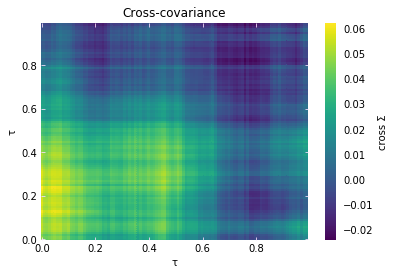

In [9]:
plt.title("Cross-covariance")
crosscov.plot(axes=[0,1]);

## Theoretical autocovariance (linear model)
$\newcommand{\Braket}[1]{\left\langle #1 \right\rangle}$
$\newcommand{\Knorm}{\mathcal{N}}$

For the linear single delay equation 
$$ \frac{d x_0}{dt} = -\alpha x_\Delta + q\,dW \,,$$
the operator's eigenvalues are given by the Lambert W function:
$$\lambda_n = \frac{W_n(-\alpha \Delta)}{\Delta} \,,$$
and the modes by
$$\phi_{n,\tau} = e^{-\lambda_n \tau} \,.$$
The time-dependent autocovariance is given by
$$\Sigma_{\tau\nu}(t) = q^2 \sum_{n,m} \Knorm_n \Knorm_m \frac{e^{(\lambda_n + \lambda_m)t} - 1}{\lambda_n + \lambda_m} \, e^{-\lambda_n\,\tau} e^{-\lambda_m\,\nu} \,.$$

In the stationary state, the relative power of each mode is given by
\begin{equation}
  P_n = \frac{\Braket{|C_n(\infty)|^2}}{\sum_k \Braket{|C_k(\infty)|^2}}
\end{equation}
\begin{equation}
  \Braket{|C_n(\infty)|^2} = -\frac{q^2 |\Knorm_n|^2}{2 \mathrm{Re}(\lambda_n)}
\end{equation}
\begin{equation}
  \Knorm_n = \frac{1}{1 + \lambda_n \Delta}
\end{equation}

In [9]:
@lru_cache()
def _λ(n, X):
    return lambertw(X.params.α*X.params.Δ, k=n) / X.params.Δ
def λ(n, X):
    if isinstance(n, np.ndarray):
        n = np.asscalar(n) if n.size == 1 else tuple(n)
        return np.array(_λ(n,X))
    else:
        return _λ(n,X)

@lru_cache()
def _Knorm(n, X):
    return 1 / (1 + λ(n, X) * X.params.Δ)
def Knorm(n, X):
    if isinstance(n, np.ndarray):
        n = np.asscalar(n) if n.size == 1 else tuple(n)
        return np.array(_Knorm(n,X))
    else:
        return _Knorm(n,X)

@lru_cache()
def _φ(n, X):
    return np.exp(-λ(n, X)*X.state_axis.stops).reshape(-1,1)
def φ(n, X):
    if isinstance(n, np.ndarray):
        n = np.asscalar(n) if n.size == 1 else tuple(n)
        return np.array(_φ(n,X))
    else:
        return _φ(n,X)

@lru_cache()
def _Σmodes(N, X, t=np.inf):
    tarr = np.array(t).reshape((-1, 1, 1))
    return params.q**2 * np.real_if_close(sum(
      Knorm(n, X) * Knorm(m, X) * ( np.exp((λ(n, X)+λ(m, X))*tarr) - 1 )
        /(λ(n, X) + λ(m, X)) * np.multiply(φ(n, X).T, φ(m, X))
      for n in range(-N, N) for m in range(-N, N)))
def Σmodes(N, X, t=np.inf):
    return np.array(_Σmodes(N, X, t=tuple(t)))

In [10]:
def P(n, X, combine=False):
    """
    
    Parameters
    ----------
    n: int, or iterable of ints
        The indices for which we want P_n.
    X: Model
        Model to use. Should be a linearized model.
    combine: bool
        If `combine=True`, returns a tuple, (P, d), composed of the value
        of relative power (P) and the number of components (1 or 2) that it represents.
        This is the appropriate way to define successively more refined approximations.
        Note that to get the total variance explained by this level, one needs to
        take `P` x `d`.
        If `combine=False`, returns the P of a single component. Components are
        ordered by eigenvalues with largest real part first, starting at 0.
        Components with same relative power are ordered arbitrarily.
        This is useful to compare e.g. the component weights with those of PCA.
        
    Returns
    -------
    If combine=False: List of Pn, one P for each entry in `n`.
    If combine=True: List of (Pn, d), one for each entry in `n`, where `d`
    is the dimensionality of the `n`-th manifold (i.e. no. of components with that relative power)
    """
    # Create an array of eigenvalues that will certainly include 'n'
    n = np.array(n)
    narr = np.arange(np.max(abs(n))+1)
    # Extend narr to include negative indexes
    narr_ext = np.sort(np.unique(np.concatenate((narr, -narr-1))))
    λreals = np.array([λ(n, X) for n in narr_ext]).real
    sort = np.argsort(λreals)
    λrealsunique = np.sort(np.unique([np.round(λreals, 5)]))[::-1]  # Hacky way of getting unique modes;
                                    # might fail in some very rare cases (https://stackoverflow.com/a/5429049)
                                    # Invert result order, [::-1], because we want the largest first
    # Compute the total variance, which we use to normalize
    totvar = sum([-X.params.q**2 * abs(Knorm(n, X))**2 / 2 / λ(n, X).real for n in range(-40, 40)])
        # Use large enough number of components to get whole variance; by experience,
        # 40 is usually a pretty good number for non-pathological linear systems.
    
    if not combine:
        Σ_ns = -X.params.q**2 * abs(Knorm(narr_ext, X))**2 / 2 / λ(narr_ext, X).real
        return Σ_ns[sort][::-1][n] / totvar
    else:
        res = []
        # Iterate over the requested modes, appending their explained variance and multiplicity to result list
        for nidx in n:
            _λ = λrealsunique[nidx]
            i = np.nonzero(np.isclose(_λ, λreals, atol=1e-4))  # Index in narr_ext corresponding to this eigenvalue
            _n = narr_ext[i][0]
            res.append((-X.params.q**2 * abs(Knorm(_n, X))**2 / 2 / λ(_n, X).real / totvar,
                        np.count_nonzero(np.isclose(_λ, λreals, atol=1e-4))))
        return res
        

In [185]:
def plot_explained_variance_modes(N, color=plot.darkcolors[0], ax=None):
    narr = np.arange(N)
    Ps = P(narr, X=X, combine=False)
    
    if ax is None:
        ax = plt.gca()
    ax.plot( narr+1, Ps, marker='o', label="Eigenmodes", color=color);
    ax.set_xlabel("mode index ($n$)");
    ax.set_ylabel("explained variance ($P_n$)");
    ax.set_yscale('log')
    ax.set_xticks(narr+1);
#plot_explained_variance_modes(6)

As a check, we compare the theoretical prediction of the variance from the linear model to our Monte Carlo estimates of the variance. We note that these estimates were done for a nonlinear model with saturating feedback, so we do expect some discrepancy.

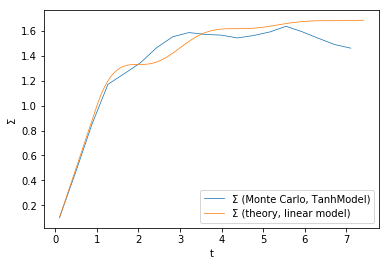

In [52]:
tarr_supersampled = utils.supersample(tarr, 5)
plt.plot(tarr, X.Σ(tarr)[:,0], label="Σ (Monte Carlo, {})".format(X.Model.__name__));
plt.plot(tarr_supersampled, Σmodes(N=40, X=X, t=tarr_supersampled)[:,0,0].real, label="Σ (theory, linear model)");
plt.legend(loc='best');
plt.xlabel("t");
plt.ylabel("Σ");

# Estimating the dimensionality of the solution space

We have argued (René & Longtin, Chaos 2017) that the effective dimensionality of a linear SDDE could be measured by the number of components which contribute variance, i.e. the number of components for which $P_n$ is non-negligible.

There is not yet a proper extension of the concept of components to nonlinear equations. To estimate their dimensionality, we used their principal components (as obtained by PCA); since PCA seeks to maximize the explained residual variance for each component, the number of components required to be within some fraction of the total variance provides a similar measure of dimensionality.

We note because PCA seeks to maximize the explained variance for each successive component (it could be qualified as 'greedy' wrt variance), the dimensionality estimate is only an upper bound. For example, sequences of components may exist where the variance captured by the first is less than that of $\mathrm{PCA}_1$, but for which the fraction of explained variance nonetheless approaches 1 faster than PCA as we increase the number of components.<br />
The eigenmodes of the linear system, although not as 'greedy', also do not explicitly optimize for maximal total explained variance.

## PCA components

We obtain the PCA components by diagonalizing the Monte Carlo estimate of the covariance matrix.

In [182]:
def plot_explained_variance_PCA(N, ax=None, color=plot.darkcolors[1]):
    narr = np.arange(N)
    if ax is None:
        ax = plt.gca()
    ax.set_title("Relative importance of PCA components")
    ax.plot(narr+1,
            X.PCA_w()[:len(narr)] / X.PCA_w().sum(),
            color=color,
            marker='o',
            label="PCA");  # Use +1 so indexing starts at 1
    ax.set_ylabel(r"$\frac{w_n}{\sum_k w_k}$", rotation='horizontal', labelpad=6);
    ax.set_xlabel("PCA index ($n$)");
    ax.set_yscale('log')
    ax.set_xticks(narr+1);
#plot_explained_variance_PCA(np.arange(5))

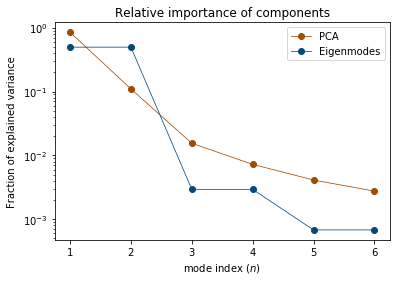

In [186]:
plot_explained_variance_PCA(6);
plot_explained_variance_modes(6);
plt.title("Relative importance of components")
plt.ylabel("Fraction of explained variance", rotation='vertical')
plt.xticks(narr+1)
plt.legend();

The first four PCA components look as follows:

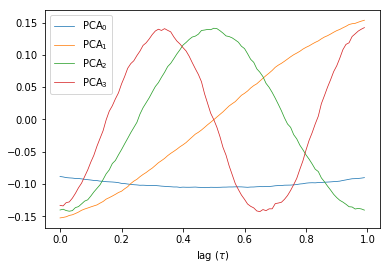

In [99]:
for i in range(0,4):
    plt.plot(X.state_axis.stops, X.PCA_φ()[:,i], label="$\\mathrm{{PCA}}_{}$".format(i))
plt.legend(loc='best');
plt.xlabel("lag ($τ$)");

For comparison, the first four eigenmodes of the linearized differential operator (imaginary parts are drawn with dashed lines):

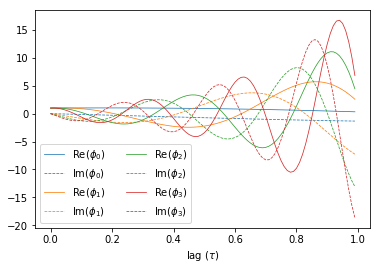

In [118]:
for n, c in zip(range(4), plot.colors):
    plt.plot(X.state_axis.stops, φ(n, X).real, color=c,
             label="$\mathrm{Re}(\\phi_"+str(n)+")$")
    plt.plot(X.state_axis.stops, φ(n, X).imag, color=c, linestyle='--',
             label="$\mathrm{Im}(\\phi_"+str(n)+")$")
plt.legend(loc='lower left', ncol=2);
plt.xlabel("lag ($τ$)");

## PCA decomposition as a function on nonlinearity

In [7]:
# Initialize four realization ensembles with different values of β

seeds = list(range(6**4))
Xlst = []
for β in (0.01, 0.1, 1., 10.):
    _params = params._replace(β=β)
    Xlst.append(core.Realizations(TanhModel, _params, seeds, cores=12,
                                  T=5, statelen=params.Δ, datadir='data'))
# X denotes an ensemble of realizations corresponding with the different seeds
for X in Xlst:
    print("Setting X with β = {}".format(X.params.β))
    X.set()
    # set() ensures that all realizations are already computed

Setting X with β = 0.01


Setting X with β = 0.1


Setting X with β = 1.0


Setting X with β = 10.0


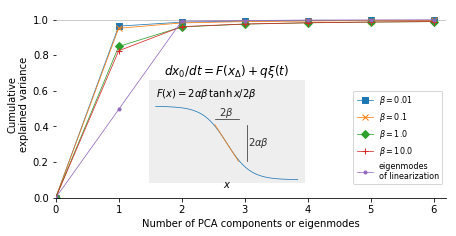

In [17]:
ncomps = 6
markers = ['s', 'x', 'D', '+']

fig = plt.figure(figsize=(7,4))
ax = plt.subplot(111)
for X, marker in zip(tqdm(Xlst), markers):
    totvar = X.PCA_w()
    ax.plot(np.arange(0, ncomps+1), np.concatenate(([0], X.PCA_w()[:ncomps].cumsum()
                                                    / X.PCA_w().sum())),
            marker=marker,
            label="$β = {}$".format(X.params.β));
Ps = P(np.arange(40), X)
plt.plot(np.concatenate((np.array([0]), Ps[:ncomps].cumsum() / Ps.sum())),
         marker='.',
         label="eigenmodes\nof linearization");
params = X.params
ax.set_xlabel("Number of PCA components or eigenmodes");
ax.set_ylabel("Cumulative\nexplained variance");
ax.set_xlim(0,ncomps+0.2);
ax.set_ylim(0,1.05)
for side, spine in ax.spines.items():
    if side != 'bottom':
        spine.set_visible(False);
ax.axhline(1, color='#BBBBBB', zorder=-1);
#ax.legend(loc='lower right');
ax.legend(loc='lower right', bbox_to_anchor=(1, 0.05), fontsize=8);

insetax = inset_axes(ax, width="100%", height="100%", loc='lower left',
                     bbox_to_anchor=(.225, 0.05, .4, .55), bbox_transform=ax.transAxes)
insetax.set_facecolor('#EEEEEE')
for spine in insetax.spines.values():
    spine.set_visible(False)
insetax.set_title("$dx_0/dt = F(x_{\Delta}) + q ξ(t)$")
α = -1; β = 1;
xarr = np.linspace(-6*β, 6*β); yarr = TanhModel.F(xarr, α, β); insetax.plot(xarr, yarr);
xarr = np.linspace(-β, β); yarr = LinearModel.F(xarr, α, β); insetax.plot(xarr, yarr);
insetax.set_xlabel('$x$', labelpad=-4)
insetax.set_ylim(2.2*α*β, -3.4*α*β)
insetax.text(-6*β, -2.5*α*β, '$F(x) = 2αβ \\, \\tanh \\, x / 2β$');
insetax.plot([-β, β], [-1.3*α*β, -1.3*α*β], color='#333333')
insetax.annotate(s='$2β$', xy=(0, -1.4*α*β), xytext = (0, -1.5*α*β), horizontalalignment='center', color='#333333')
insetax.plot([1.7*β, 1.7*β], [α*β, -α*β], color='#333333')
insetax.annotate(s='$2αβ$', xy=(1.7*β, 0), xytext=(1.8*β, 0), verticalalignment='center', horizontalalignment='left', color='#333333')
insetax.set_xticks([]);
insetax.set_yticks([]);
del α, β

#ax.text(-1.3, 1.03, "(a)", fontsize='large', fontweight='bold', verticalalignment='top');
fig.subplots_adjust(top=0.85, bottom=0.2)

plt.savefig("figures/nonlinear-pca-decomposition.pdf", bbox_inches='tight')